In [66]:
import csv
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import *
from math import sqrt
from tqdm import tqdm
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.ensemble import RandomForestRegressor
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [67]:
Data = pd.DataFrame.from_csv("normalizedData.csv")
Data

,Appliances,lights,temp_kitchen,hum_kitchen,temp_living,hum_living,temp_laundry,hum_laundry,temp_office,hum_office,...,Num_sec_midnight,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,WeekDay,Weekend
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,3.301180,-1.118616,1.843774,-0.520398,1.073656,-1.235032,1.686087,-0.908194,1.506399,...,-0.007118,-0.410408,2.470571,-0.401176,-0.401176,-0.413353,-0.413353,-0.413353,0.619379,0.0
2016-01-11 17:10:00,60,3.301180,-1.118616,1.616766,-0.520398,1.057071,-1.235032,1.704523,-0.908194,1.604488,...,140.474197,-0.410408,2.470571,-0.401176,-0.401176,-0.413353,-0.413353,-0.413353,0.619379,0.0
2016-01-11 17:20:00,50,3.301180,-1.118616,1.517921,-0.520398,1.033523,-1.235032,1.748563,-0.944091,1.580878,...,-0.007118,-0.410408,2.470571,-0.401176,-0.401176,-0.413353,-0.413353,-0.413353,0.619379,0.0
2016-01-11 17:30:00,50,4.561263,-1.118616,1.459284,-0.520398,1.024514,-1.235032,1.769047,-0.962039,1.542487,...,-0.007118,-0.410408,2.470571,-0.401176,-0.401176,-0.413353,-0.413353,-0.413353,0.619379,0.0
2016-01-11 17:40:00,60,4.561263,-1.118616,1.526298,-0.520398,1.009771,-1.235032,1.769047,-0.962039,1.497953,...,-0.007118,-0.410408,2.470571,-0.401176,-0.401176,-0.413353,-0.413353,-0.413353,0.619379,0.0
2016-01-11 17:50:00,50,4.561263,-1.118616,1.449232,-0.520398,1.002400,-1.235032,1.748563,-0.962039,1.544022,...,-0.007118,-0.410408,2.470571,-0.401176,-0.401176,-0.413353,-0.413353,-0.413353,0.619379,0.0
2016-01-11 18:00:00,60,5.821345,-1.118616,1.383894,-0.520398,1.002400,-1.235032,1.738321,-0.962039,1.557843,...,-0.007118,-0.410408,2.470571,-0.401176,-0.401176,-0.413353,-0.413353,-0.413353,0.619379,0.0
2016-01-11 18:10:00,60,5.821345,-1.139371,1.331958,-0.520398,1.002400,-1.264941,1.738321,-0.962039,1.574735,...,-0.007118,-0.410408,2.470571,-0.401176,-0.401176,-0.413353,-0.413353,-0.413353,0.619379,0.0
2016-01-11 18:20:00,60,4.561263,-1.180880,1.341382,-0.520398,0.986019,-1.264941,1.704523,-0.962039,1.557843,...,-0.007118,-0.410408,2.470571,-0.401176,-0.401176,-0.413353,-0.413353,-0.413353,0.619379,0.0


In [68]:
train = pd.DataFrame.from_csv("train.csv")
test = pd.DataFrame.from_csv("test.csv")
X_train = train.iloc[:,:len(train.columns)-1]
y_train = train.iloc[:,len(train.columns)-1]
X_test = test.iloc[:,:len(test.columns)-1]
y_test = test.iloc[:,len(test.columns)-1]

# Sequential Forward Selection of feature in RandomForest

In [74]:
regressor = RandomForestRegressor(n_estimators=200, n_jobs=4)
sfs1 = SFS(regressor,
           k_features=15,
           forward=True, 
           floating=False,
           scoring='r2',verbose=2,
           n_jobs=4,
           cv=0)
sfs1 = sfs1.fit(X_train.as_matrix(), y_train.as_matrix())

[Parallel(n_jobs=4)]: Done  37 out of  37 | elapsed:   40.8s finished

[2018-03-16 14:30:26] Features: 1/15 -- score: 0.800534237168[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  2.0min finished

[2018-03-16 14:32:26] Features: 2/15 -- score: 0.849217606566[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  2.3min finished

[2018-03-16 14:34:46] Features: 3/15 -- score: 0.880220006915[Parallel(n_jobs=4)]: Done  34 out of  34 | elapsed:  2.8min finished

[2018-03-16 14:37:31] Features: 4/15 -- score: 0.916644839565
STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [71]:
sfs1.subsets_

{1: {'avg_score': 0.80244644302583656,
  'cv_scores': array([ 0.80244644]),
  'feature_idx': (26,)},
 2: {'avg_score': 0.84825737097933451,
  'cv_scores': array([ 0.84825737]),
  'feature_idx': (2, 26)}}

C:\Users\gaurang\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\gaurang\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


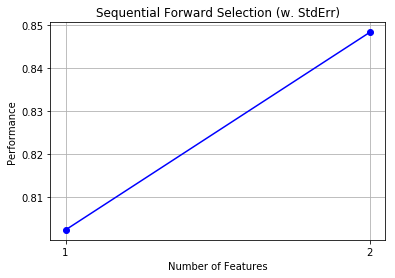

In [72]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

# Sequential Backward Selection of feature in RandomForest

In [41]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=4, verbose =2)
sfs1 = SFS(regressor,
           k_features=10,
           forward=False, 
           floating=False,
           scoring='r2', verbose=2,
           n_jobs=4,
           cv=0)
sfs1 = sfs1.fit(X_train.as_matrix(), y_train.as_matrix())

[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  9.8min finished

[2018-03-16 04:11:09] Features: 35/10 -- score: 0.936658372666[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  8.7min finished

[2018-03-16 04:19:54] Features: 34/10 -- score: 0.937997825388[Parallel(n_jobs=4)]: Done  34 out of  34 | elapsed:  8.3min finished

[2018-03-16 04:28:14] Features: 33/10 -- score: 0.939830965982[Parallel(n_jobs=4)]: Done  33 out of  33 | elapsed:  7.6min finished

[2018-03-16 04:35:52] Features: 32/10 -- score: 0.940933336582[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:  7.0min finished

[2018-03-16 04:42:51] Features: 31/10 -- score: 0.940979745656[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:  6.9min finished

[2018-03-16 04:49:48] Features: 30/10 -- score: 0.940769853002[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  6.5min finished

[2018-03-16 04:56:18] Features: 29/10 -- score: 0.942285785497[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:  6.0min finished

In [42]:
sfs1.subsets_

{10: {'avg_score': 0.94268894490623512,
  'cv_scores': array([ 0.94268894]),
  'feature_idx': (8, 9, 10, 12, 13, 14, 19, 20, 21, 23)},
 11: {'avg_score': 0.94256802112520832,
  'cv_scores': array([ 0.94256802]),
  'feature_idx': (3, 8, 9, 10, 12, 13, 14, 19, 20, 21, 23)},
 12: {'avg_score': 0.94246879041156706,
  'cv_scores': array([ 0.94246879]),
  'feature_idx': (3, 8, 9, 10, 12, 13, 14, 17, 19, 20, 21, 23)},
 13: {'avg_score': 0.94264942306002097,
  'cv_scores': array([ 0.94264942]),
  'feature_idx': (3, 8, 9, 10, 11, 12, 13, 14, 17, 19, 20, 21, 23)},
 14: {'avg_score': 0.9427262799104873,
  'cv_scores': array([ 0.94272628]),
  'feature_idx': (3, 8, 9, 10, 11, 12, 13, 14, 17, 19, 20, 21, 23, 29)},
 15: {'avg_score': 0.94267351045972669,
  'cv_scores': array([ 0.94267351]),
  'feature_idx': (3, 8, 9, 10, 11, 12, 13, 14, 17, 19, 20, 21, 23, 29, 35)},
 16: {'avg_score': 0.94313699740616519,
  'cv_scores': array([ 0.943137]),
  'feature_idx': (3,
   8,
   9,
   10,
   11,
   12,
   13,


C:\Users\gaurang\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\gaurang\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


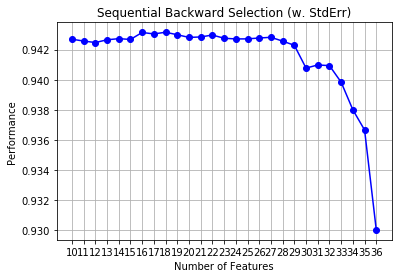

In [43]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')
plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [44]:
sfs1.k_feature_idx_

(8, 9, 10, 12, 13, 14, 19, 20, 21, 23)

In [62]:
X_train.columns

Index(['lights', 'temp_kitchen', 'hum_kitchen', 'hum_living', 'temp_laundry',
       'hum_laundry', 'temp_office', 'hum_office', 'temp_bathroom',
       'hum_bathroom', 'temp_building_out', 'hum_building_out', 'temp_ironing',
       'hum_ironing', 'temp_teenRoom', 'hum_teenRoom', 'temp_parentRoom',
       'hum_parentRoom', 'temp_out', 'Pressure', 'hum_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'Num_sec_midnight', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'WeekDay', 'Weekend'],
      dtype='object')

# Sequential Exhaustive Selection of feature in RandomForest

In [65]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=4, verbose =2)
efs = EFS(regressor, n_jobs=4, max_features=15, cv = 0, scoring='r2')
efs.fit(X_train.as_matrix(), y_train.as_matrix())

KeyboardInterrupt: 

C:\Users\gaurang\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\gaurang\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


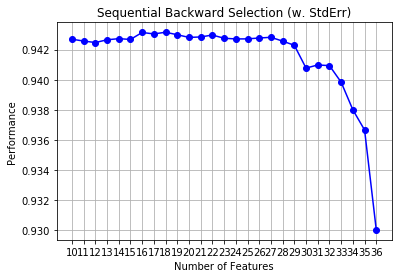

In [43]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')
plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
df_shift, y = make_forecasting_frame(Data["Appliances"], kind="Watts", max_timeshift=20, rolling_direction=1)

In [ ]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,show_warnings=False)

***********
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

************
X = X.iloc[1:, ]
y = y.iloc[1: ]

************
y_pred = lm.predict(X)

In [2]:
SFS()

NameError: name 'SFS' is not defined